In [2]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# DeepTrack.features

This notebook introduces the module DeepTrack.features.

## What is a feature?

Features are instances of the abstract class `Feature` and are responsible for modifying images. For example, a feature might add the image of a particle or add some salt-and-pepper noise. Features are instances of the abstract class `Feature` and are responsible for modifying images. For example, a feature might add the image of a particle or add some salt-and-pepper noise. 

Each implementation of the class `Feature` needs to define a method `get(image, **kwargs)`, which takes an image as an input and returns an updated image. This can be additive, such as adding a particle or Gaussian noise, or non-additive, such as introducing Poisson noise or performing a low-pass filter. The image that is modified is in itself an instance of the class Image, which for now can be thought of as a numpy ndarray.

When a feature is created, keyword arguments can be passed to its constructor. These arguments are stored as [properties](properties_example.ipynb) (as a PropertyDict) of the feature, which determine how the feature is resolved. When a feature is updated using the method `update()`, all of the properties are updated as well by calling their respective methods `update()`. When a feature is resolved using the method `resolve(image)`, the current values of all properties are sent through the method `get(image, **kwargs)` as keyword arguments.

In [11]:
import numpy as np

from DeepTrack.features import Feature
from DeepTrack.Image import Image

# Implementation of abstract class Feature 
# that does not alter the image 
# and prints the current value of my_property
class Foo(Feature):
    def get(self, image, my_property=None):
        print("The current value of my_property is", my_property) # the current value of my_property is passed to the get function
        return image

input_image = Image([])

foo1 = Foo(my_property=1)
output_image = foo1.resolve(input_image)

foo2 = Foo(my_property="bar")
output_image = foo2.resolve(input_image)

foo3 = Foo()
output_image = foo3.resolve(input_image)

The current value of my_property is 1
The current value of my_property is bar
The current value of my_property is None


Since the values are stored as instances of Property, you can always replace values with standard structures such as lists or lambda functions to create more complicated behaviors

In [13]:
foo4 = Foo(my_property=lambda: np.random.rand() - 0.5)
output_image = foo4.resolve(input_image)

foo5 = Foo(my_property=["bar", "baz"])
output_image = foo5.resolve(input_image)

The current value of my_property is -0.02783904724600217
The current value of my_property is baz


## Operations defined on features

Features can be combined to create a feature series, which is a series of features that are evaluated sequentially. This is done using the add operator (+), the multiply operator (\*), and the power operator (\*\*).

### Adding features (+)

The add operator (+) combines two features such that the output of the left side is set as the input to the feature to the right. For example, `foobar = foo + bar`, where foo and bar are features. Here, when an image is resolved from foobar, it first resolves an image from foo, then uses this image as the input to resolve an image from bar.

This operation returns a `FeatureBranch` instance, which contains the two features.

In [7]:
foobar = Foo(my_property="foo") + Foo(my_property="bar")

output_image = foobar.resolve(input_image)

The current value of my_property is foo
The current value of my_property is bar


### Multiplying feature with number (\*)

Multiplying a feature `F` with a number `p` creates a new feature that has a proability `p` of resolving the feature `F`, and a probability `1-p` to return the input image without modifying it. 

In [14]:
foo = Foo(my_property=0) * 0.5
for i in range(1, 10):
    foo = foo + Foo(my_property=i) * 0.5
    
# foo is here 10 instances of Foo, each with a 50 % chance of being resolved.

output_image = foo.resolve(input_image)

The current value of my_property is 0
The current value of my_property is 1
The current value of my_property is 3
The current value of my_property is 8
The current value of my_property is 9


### Exponentiating feature with integer (\*\*)

The pow operator (\*\*) takes a feature `F` and an integer `i` and creates `i` deep copies of the feature, which are added to the feature series at resolve time.  Since this is done at resolve time, the right hand side can be any value that returns an integer when sampled. For example, `Foo()**5` will create 5 deep copies of the instance of Foo and add them to the feature series.

Note that that since the features are deep copied, properties that reference these features may produce unintended results. 

In [16]:
foo = Foo(my_property = ["bar", "baz", "qux", "quux"]) 

output_image = (foo**5).resolve(input_image)

The current value of my_property is quux
The current value of my_property is qux
The current value of my_property is quux
The current value of my_property is baz
The current value of my_property is baz


In [19]:
output_image = (foo**[3, 4, 5]).resolve(input_image)

The current value of my_property is baz
The current value of my_property is bar
The current value of my_property is quux


## Example - Image with random circles

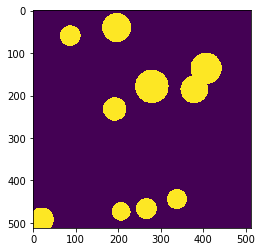

In [23]:
from matplotlib import pyplot as plt


# Implementation of the abstract class Feature that draws a circle on an image.
class Circle(Feature):
    def get(self, image, position=None, radius=None, intensity=None):
        X, Y = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]))
        mask = (X - position[0])**2 + (Y - position[1])**2 < radius**2
        image[mask] = intensity
        return image

circle = Circle(
    position=lambda: np.random.rand(2) * 512,
    radius=lambda: 20 + np.random.rand() * 20,
    intensity=1
)

input_image = Image(np.zeros((512, 512)))

output_image = (circle**10).resolve(input_image) 

plt.imshow(output_image)
plt.show()

## Example - Image with stacked circles

It's not unusual for a feature to depend on some other feature. Due to the way features are updated, we can only reliably depend on features that are resolved earlier in the sequence. Dependent features can typically not be wrapped by a \*\* operator, since the reference pointers will not be correctly copied. 

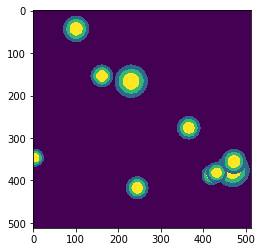

In [24]:
# Due to python scoping rules, we need to move this evaluation
# to its own scope. This is why we use wrapped function instead
# of lambda functions.
def get_position(base):
    def func():
        return base.properties["position"].current_value
    return func

def get_radius(base, mul_factor):
    def func():
        return base.properties["radius"].current_value*mul_factor
    return func

# Since layer1 references the instance "base", we can't use the ** syntax
# to duplicate the feature. Instead we use a for-loop.
for i in range(10):
    
    base = Circle(
        position=lambda: np.random.rand(2) * 512,
        radius=lambda: 20 + np.random.rand() * 20,
        intensity=1
    )
   
    layer1 = Circle(
        position=get_position(base),
        radius=get_radius(base, 0.75),
        intensity=2
    )

    layer2 = Circle(
        position=get_position(base),
        radius=get_radius(base, 0.5),
        intensity=3
    )
    
    stack = base + layer1 + layer2
    
    if i == 0:
        features = stack
    else: 
        features = features + stack
        
input_image = Image(np.zeros((512, 512)))
output_image = features.resolve(input_image) 

plt.imshow(output_image)
plt.show()

## Example - Image with pow operator friendly stacked circles 

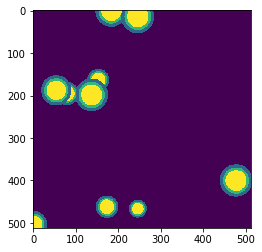

In [26]:
# We create a new Feature subclass that takes a list of features and
# updates the position and radius values of every feature in the list
# before resolving them.
class StackedCircles(Feature):
    def get(self, image, position=None, radius=None, feature_list=None):
        
        for feature in feature_list:
            feature.properties["position"].current_value = position
            feature.properties["radius"].current_value = radius
            
            radius *= 0.8
            image = feature.resolve(image)
            
        return image

    
base = Circle(
    position=None,
    radius=None,
    intensity=1
)

layer1 = Circle(
    position=None,
    radius=None,
    intensity=2
)

layer2 = Circle(
    position=None,
    radius=None,
    intensity=3
)

stack = StackedCircles(
    position=lambda: np.random.rand(2) * 512,
    radius=lambda: 20 + 20 * np.random.rand(),
    feature_list=lambda: [base, layer1, layer2]
)

input_image = Image(np.zeros((512, 512)))
output_image = (stack**10).resolve(input_image) 

plt.imshow(output_image)
plt.show()

## Example - Image with random non-overlapping circles

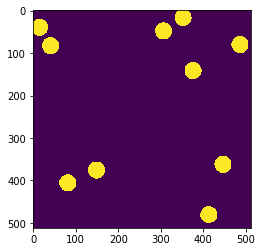

In [36]:
from matplotlib import pyplot as plt

RADIUS = 20 # Fixed radius since accessing properties of self is more difficult.

# Function that returns a position that is atleast 2 * radius away from every other
# circle in the parameter `previous`.
def NonOverlappingPosition(previous, position_function, radius):
    def func():
        
        prev_positions = [circle.properties["position"].current_value for circle in previous]
        
        prev_radius = [circle.properties["radius"].current_value for circle in previous]

        overlapping = True
        while overlapping:
            position = position_function()
            overlapping = any([np.sum((position - prev_position)**2) < radius**2 * 2 for prev_position in prev_positions])
        return position
    return func
            
    
circles = []
for i in range(10):
    # Create the circle instance
    circle = Circle(
        position=NonOverlappingPosition(circles[:], lambda: np.random.rand(2) * 512, RADIUS),
        radius=RADIUS,
        intensity=1
    )
    circles.append(circle)
    
    if i == 0:
        circle_features = circle
    else:
        circle_features = circle_features + circle


input_image = Image(np.zeros((512,512)))
output_image = circle_features.resolve(input_image) 

plt.imshow(output_image)
plt.show()